## Loading initial excel file

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('data/SOFT-3.xlsx', header=1)
df = df.drop(df.columns[0], axis=1)
df.head()

,student,company
0,Benjamin Curovic,Dynatest A/S
1,Jacob Simonsen,"Eriksholm Research Centre, Oticon"
2,Sebastian Godsk Hansen,Formpipe
3,Lukas Bang Stoltz-Andersen,Formpipe
4,Christoffer Ikizek Wegner,Formpipe


## Anonymising the data (student names)

In [3]:
from faker import Faker

faker = Faker()
dict_names = {name: faker.name() for name in df['student'].unique()}
df['student'] = df['student'].map(dict_names)
df.head()

,student,company
0,Linda Rivera,Dynatest A/S
1,Tiffany Short,"Eriksholm Research Centre, Oticon"
2,Lisa Wallace,Formpipe
3,Bryce Taylor,Formpipe
4,Alan Hayes,Formpipe


## Getting company data with CVR API

In [4]:
import requests

In [5]:
df['company'].unique().size

12

In [6]:
def get_company_data(company):
    # Specifically uses the company name search of the API, not the general search.
    r = requests.get('https://cvrapi.dk/api', params={
        'name': company,
        'country': 'dk',
        'format': 'json'
    })
    return r.json()

This is a refactored version of the two cells below it for getting and storing JSON data

In [7]:
from modules.utils import json_or_get

These are the older deprecated cells that fetched and stored data about the companies.

In [8]:
# import json
# from os.path import exists

# # init empty dict
# dict_company_data = {}
# # loads from json file if exists
# path = 'data/company_data.json'
# if exists(path):
#     with open(path) as f:
#         dict_company_data = json.load(f)

In [9]:
# # if company from df is not in the existing json file, we get info from API
# for company in df['company'].unique():
#     if company not in dict_company_data.keys():
#         dict_company_data[company] = get_company_data(company)

# # overwrite existing json file with fresh data
# with open(path, 'w') as f:
#     json.dump(dict_company_data, f)

In [10]:
dict_company_data = json_or_get('data/company_data.json', df['company'].unique(), get_company_data)

In [11]:
df_company = pd.DataFrame.from_dict(dict_company_data, orient='index')
df_company.head()

,vat,name,address,zipcode,city,cityname,protected,phone,email,fax,...,industrydesc,companycode,companydesc,creditstartdate,creditbankrupt,creditstatus,owners,productionunits,t,version
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,None,False,NaN,None,NaN,...,Uoplyst,60,Aktieselskab,12/03 - 2001,True,1.0,None,"[{'pno': 1004239898, 'main': True, 'name': 'A/...",100,6
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,None,False,NaN,None,NaN,...,"Andre liberale, videnskabelige og tekniske tje...",60,Aktieselskab,None,False,NaN,None,"[{'pno': 1001942680, 'main': True, 'name': 'PR...",100,6
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,None,False,43660210.0,admin.lasernet@formpipe.com,NaN,...,Anden udgivelse af software,60,Aktieselskab,None,False,NaN,[{'name': 'Formpipe Software AB'}],"[{'pno': 1008829868, 'main': True, 'name': 'FO...",100,6
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,None,False,44448888.0,None,NaN,...,Fremstilling af farmaceutiske præparater,60,Aktieselskab,None,False,NaN,None,"[{'pno': 1017661031, 'main': False, 'name': 'N...",100,6
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,None,False,70808500.0,post@pfabank.dk,39172950.0,...,"Banker, sparekasser og andelskasser",60,Aktieselskab,None,False,NaN,None,"[{'pno': 1013750293, 'main': True, 'name': 'PF...",100,6


## Get more data from Proff
Because we don't have access to the API, and there's no way that I can see of deducing the URL to the company page, I will just make a `list` of URLs to scrape, one for each company. The annoying part is having to update this when new companies are added. Same goes for the URLs below when we do text vectorisation.

In [12]:
import requests
from bs4 import BeautifulSoup
from modules.urls import proff_urls, website_urls
from urllib.parse import urlparse

In [13]:
def proff_url_regnskab(url):
    """Returns the url to the regnskab page of a proff.dk url"""
    # Using urllib to parse the url and replace the first path element
    # Could've used string manipulation to replace 'firma' with 'regnskab', but that could be error prone
    # Could've also used split and join on the string, but this seems more robust. Specifically targets the path of the URL.
    parsed = urlparse(url)
    path = parsed.path.split('/')
    path[1] = 'regnskab'                                    # will error if path is empty (a single '/' is good enough)
    return parsed._replace(path='/'.join(path)).geturl()    # geturl should be the same as urlunparse(parsed)

def get_proff_employee_count(url):
    """Returns the number of employees from a proff.dk url"""
    r = requests.get(url)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, 'html.parser')
    employees = soup.select_one('li.employees-info > em')
    return int(employees.text) if employees else None

def get_proff_financial_data(url):
    """Returns the financial data from a proff.dk url"""
    # I could use bs4 to get the table and pass to pandas, but it's easier to just use pandas to find it
    # The match parameter is used to only get the table with the correct header
    df = pd.read_html(url, match='RESULTATREGNSKAB', index_col=0, encoding='utf-8', na_values='-')[0]

    # get result row as new series to avoid it being a view
    # I could've not indexed the df or used iloc here, and then the encoding wouldn't have been an issue
    s = pd.Series(df.loc['Årets resultat'])

    # drop last index
    s.drop(s.index[-1], inplace=True)
    # remove month from year-month index
    s.rename(lambda i: i.split('-')[0] , inplace=True)
    # remove dots and replace commas with dots, then convert to float
    s = s.apply(lambda x: x.replace('.', '').replace(',', '.') if isinstance(x, str) else x).astype(float)
    return s

def get_proff_data(url):
    """
    Fetches data from proff.dk and returns it as a dict.

    It contains the number of employees and the financial data.
    """
    print(url)
    employees  = get_proff_employee_count(url)

    url = proff_url_regnskab(url)
    finances = get_proff_financial_data(url)
    finances['employees'] = employees
    return finances.to_dict()

In [14]:
proff_data = json_or_get('data/proff_data.json', proff_urls, get_proff_data)

Now that we have the data from Proff, we can add it to our dataframe.

In [16]:
# from_dict has a messed up row order, so we transpose it
df_proff = pd.DataFrame(proff_data).T
df_proff.set_index(df_company.index, inplace=True)
df_proff

,2022,2021,2020,employees,2019,2018,2017,2016,2015,2014,2013
Dynatest A/S,3581.0,9606.0,4530.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Eriksholm Research Centre, Oticon",NaN,1525319.0,165416.0,42.0,551594.0,962573.0,1011568.0,743559.0,730954.0,535275.0,798601.0
Formpipe,NaN,36583.0,14719.0,87.0,7525.0,10511.0,-748.0,-4924.0,-4145.0,-590.0,-7751.0
Novo Nordisk,NaN,47523000.0,42159000.0,22150.0,39252000.0,38530000.0,37873000.0,37791000.0,34623000.0,26413000.0,25190000.0
PFA,-511000.0,-79000.0,108000.0,1464.0,10000.0,92000.0,181000.0,136000.0,-587000.0,548000.0,224000.0
Topdanmark,NaN,2138000.0,NaN,8.0,1547000.0,1331000.0,1733000.0,1536000.0,1132000.0,1558000.0,1468000.0
KMD A/S,53926.0,2893.0,173758.0,1855.0,-238596.0,NaN,177700.0,244400.0,500600.0,81800.0,53100.0
NorthTech ApS,NaN,5.0,598.0,20.0,792.0,1124.0,1010.0,1497.0,1931.0,672.0,362.0
Alpha Solutions,3477.0,4334.0,-2940.0,59.0,-3279.0,4171.0,3385.0,2243.0,5079.0,3439.0,2500.0
Dafolo,36271.0,1339.0,40.0,83.0,3162.0,-489.0,-5862.0,-2121.0,1439.0,4170.0,844.0


The column order is slightly messed up because employees is encountered before the rest of the years, so we could move it to the front with `pop` and `insert`.

```python
df_proff.insert(0, 'employees', df_proff.pop('employees'))
```

However, we actually want to just replace the original column.

In [17]:
df_company['employees'] = df_proff.pop('employees')

In [18]:
df_company = pd.concat([df_company, df_proff], axis=1)

## Cleaning the company DataFrame

In [19]:
# Amount of non-nan values per column.
df_company.count()

vat                12
name               12
address            12
zipcode            12
city               12
cityname            0
protected          12
phone               8
email               6
fax                 3
startdate          12
enddate             1
employees          12
addressco           0
industrycode       12
industrydesc       12
companycode        12
companydesc        12
creditstartdate     1
creditbankrupt     12
creditstatus        1
owners              2
productionunits    12
t                  12
version            12
2022                5
2021               12
2020               11
2019               11
2018               10
2017               10
2016               10
2015               10
2014               10
2013               10
dtype: int64

In [20]:
# specifically the missing values of the financial data
df_company.loc[:,'2022':].isna().sum()

2022    7
2021    0
2020    1
2019    1
2018    2
2017    2
2016    2
2015    2
2014    2
2013    2
dtype: int64

In [21]:
df_company.drop('2022', axis=1, inplace=True)

In [22]:
no_rows = df_company.shape[0]
df_company.dropna(axis=1, thresh=no_rows * 0.1, inplace=True)   # drops columns with 90 % missing data

In [23]:
def all_same(series):
    return (series == series[0]).all()

cols_with_same_vals = [col for col in df_company.columns if col != 'productionunits' and all_same(df_company[col])]
print(cols_with_same_vals)
df_company.drop(cols_with_same_vals, axis=1, inplace=True)

['t', 'version']


In [24]:
# drop various columns I don't want
df_company.drop(['protected', 'fax', 'companycode', 'companydesc', 'owners'], axis=1, inplace=True)

In [25]:
# removes floor of addresses to format for geo coordinates search.
df_company['address'] = df_company['address'].apply(lambda a: a.split(',')[0])

In [26]:
df_company.to_csv('data/cleaned_data.csv')

## Geolocation data

In [27]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='python-school-cphbusiness')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_geo_data(address):
    loc = geocode(address)
    # could use a dict to specify the format, but then I have to worry about formatting. Not all the city names are valid either.
    # a straight search is easier to do
    return (loc.latitude, loc.longitude) if loc else (None, None)

In [28]:
geo_data = json_or_get('data/geo_data.json', df_company['address'], get_geo_data)

In [29]:
# unzips the coordinate tuples
lats, lons = zip(*geo_data.values())
df_company['latitude'] = lats
df_company['longitude'] = lons
df_company.to_csv('data/cleaned_data.csv')

In [30]:
import folium

first_coords = df_company.iloc[0][['latitude', 'longitude']]
m = folium.Map(location=first_coords, zoom_start=12)
for idx, row in df_company.iterrows():
    folium.Marker(row[['latitude', 'longitude']], popup=f"<b>{row['name']}</b> <i>{row['industrydesc']}</i>").add_to(m)
m.save('renders/map.html')
m

## Vectorisation

In [31]:
df_company = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [32]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer('all-MiniLM-L6-v2')

c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
corpus_embeddings = embedder.encode(df_company['industrydesc'])

### Which two companies are closest?

In [34]:
idx1 = 0
idx2 = 0
score = 0

for i, query_embedding in enumerate(corpus_embeddings):
    for j, corpus_embedding in enumerate(corpus_embeddings):
        sim = util.cos_sim(query_embedding, corpus_embedding)
        val = sim.tolist()[0][0]
        # if new max similarity and not matching self
        if score < val and i != j:
            idx1 = i
            idx2 = j
            score = val

print(idx1, idx2, score)
print(df_company.iloc[[idx1, idx2]][['name', 'industrydesc']])

6 8 1.0
                                name  \
KMD A/S                      KMD A/S   
Alpha Solutions  ALPHA SOLUTIONS A/S   

                                                      industrydesc  
KMD A/S          Konsulentbistand vedrørende informationsteknologi  
Alpha Solutions  Konsulentbistand vedrørende informationsteknologi  


### Scraping

In [35]:
df_company.index

Index(['Dynatest A/S', 'Eriksholm Research Centre, Oticon', 'Formpipe',
       'Novo Nordisk', 'PFA', 'Topdanmark', 'KMD A/S', 'NorthTech ApS',
       'Alpha Solutions', 'Dafolo', 'Nuuday A/S', 'Netcompany A/S'],
      dtype='object')

In [36]:
def get_website_text(url):
    r = requests.get(url)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, 'html.parser')
    tags = soup.select('h1, h2, p')
    return [tag.text for tag in tags]

In [37]:
texts = json_or_get('data/website_text.json', website_urls, get_website_text)
texts = {k: ' '.join(v) for k, v in texts.items()}
# joins list of paragraphs for each website because I think that's what I actually need.

In [38]:
corpus_embeddings = embedder.encode(list(texts.values()))

### Querying

In [39]:
queries = ['Software','development', 'udvikling', 'programmering', 'programming']
query_embedding = embedder.encode(queries)

In [40]:
for idx, embedding in enumerate(corpus_embeddings):
    sim = util.cos_sim(query_embedding, embedding)
    print("{}:\t\t{:.4f}".format(df_company.iloc[idx]['name'], sim.tolist()[0][0]))

A/S DYNATEST ENGINEERING:		0.1169
PROPOLIS RESEARCH CENTRE A/S:		0.1714
FORMPIPE LASERNET A/S:		0.1248
NOVO NORDISK A/S:		0.1259
PFA BANK A/S:		-0.0880
TOPDANMARK A/S:		0.1361
KMD A/S:		0.1953
NORTHTECH ApS:		0.2179
ALPHA SOLUTIONS A/S:		0.2515
DAFOLO A/S:		0.1993
Nuuday A/S:		0.1135
Netcompany A/S:		0.1811


Whelp. Nuuday is the highest scoring even though it had literally 0 `<p>` tags. It's a JS website so we need Selenium to get proper data there.

I've changed the selector to include `<h1>` and `<h2>`. That might make it more accurate.

In [41]:
df_company

,vat,name,address,zipcode,city,phone,email,startdate,employees,industrycode,...,2020,2019,2018,2017,2016,2015,2014,2013,latitude,longitude
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,NaN,NaN,15/10 - 1981,36.0,980000,...,4530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.729930,12.464800
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,NaN,NaN,10/09 - 1974,42.0,749090,...,165416.0,551594.0,962573.0,1011568.0,743559.0,730954.0,535275.0,798601.0,55.757949,12.228728
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,43660210.0,admin.lasernet@formpipe.com,13/12 - 2001,87.0,582900,...,14719.0,7525.0,10511.0,-748.0,-4924.0,-4145.0,-590.0,-7751.0,55.733204,12.391164
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,44448888.0,NaN,28/11 - 1931,22150.0,212000,...,42159000.0,39252000.0,38530000.0,37873000.0,37791000.0,34623000.0,26413000.0,25190000.0,55.754555,12.455185
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,70808500.0,post@pfabank.dk,02/11 - 2007,1464.0,641900,...,108000.0,10000.0,92000.0,181000.0,136000.0,-587000.0,548000.0,224000.0,55.708655,12.591288
Topdanmark,78040017,TOPDANMARK A/S,Borupvang 4,2750,Ballerup,70158585.0,NaN,20/05 - 1985,8.0,642010,...,NaN,1547000.0,1331000.0,1733000.0,1536000.0,1132000.0,1558000.0,1468000.0,55.734142,12.380579
KMD A/S,26911745,KMD A/S,Lautrupparken 40,2750,Ballerup,44601000.0,info@kmd.dk,03/12 - 2002,1855.0,620200,...,173758.0,-238596.0,NaN,177700.0,244400.0,500600.0,81800.0,53100.0,55.736130,12.393105
NorthTech ApS,10121361,NORTHTECH ApS,Wildersgade 51,1408,København K,NaN,kontakt@northtech.dk,20/01 - 2003,20.0,620100,...,598.0,792.0,1124.0,1010.0,1497.0,1931.0,672.0,362.0,55.674321,12.591612
Alpha Solutions,27506488,ALPHA SOLUTIONS A/S,Gothersgade 14,1123,København K,70206538.0,NaN,01/01 - 2004,59.0,620200,...,-2940.0,-3279.0,4171.0,3385.0,2243.0,5079.0,3439.0,2500.0,55.682038,12.583964
Dafolo,61966617,DAFOLO A/S,Suderbovej 22-24,9900,Frederikshavn,96206666.0,dafolo@dafolo.dk,06/12 - 1962,83.0,581100,...,40.0,3162.0,-489.0,-5862.0,-2121.0,1439.0,4170.0,844.0,57.445530,10.493744


## Data engineering

In [42]:
import numpy as np
import seaborn as sns

In [43]:
shape = df_company.shape
print(shape)
print(f"No. rows: {shape[0]}")
print(f"No. columns: {shape[1]}")

(12, 24)
No. rows: 12
No. columns: 24


In [44]:
df_company.dtypes

vat                  int64
name                object
address             object
zipcode              int64
city                object
phone              float64
email               object
startdate           object
employees          float64
industrycode         int64
industrydesc        object
creditbankrupt        bool
productionunits     object
2021               float64
2020               float64
2019               float64
2018               float64
2017               float64
2016               float64
2015               float64
2014               float64
2013               float64
latitude           float64
longitude          float64
dtype: object

In [45]:
numerical_cols = df_company.select_dtypes(np.number).columns
numerical_cols

Index(['vat', 'zipcode', 'phone', 'employees', 'industrycode', '2021', '2020',
       '2019', '2018', '2017', '2016', '2015', '2014', '2013', 'latitude',
       'longitude'],
      dtype='object')

Really, only `employees` is proper numerical. And the coordinates but eh.

Since scraping financial data from Proff.dk, all of that is numerical as well.

In [46]:
employees = df_company.employees
print(f'Missing values:\t{employees.isna().sum()}')
print(f'Mean:\t\t{employees.mean()}')
print(f'Median:\t\t{employees.median()}')
print(f'Mode:\n{employees.mode()}')
print(f'Min:\t\t{employees.min()}')
print(f'Max:\t\t{employees.max()}')
print(f'Range:\t\t{employees.max() - employees.min()}')
print(f'Variance:\t\t{employees.var()}')
print(f'Standard deviation:\t{employees.std()}')

Missing values:	0
Mean:		2648.8333333333335
Median:		85.0
Mode:
0         8.0
1        20.0
2        36.0
3        42.0
4        59.0
5        83.0
6        87.0
7      1464.0
8      1855.0
9      2340.0
10     3642.0
11    22150.0
Name: employees, dtype: float64
Min:		8.0
Max:		22150.0
Range:		22142.0
Variance:		39161111.969696976
Standard deviation:	6257.883984998202


Mode is all of them because no one value is repeated. They all have different amounts of employees.

In [47]:
# instead of printing everything separately
# .describe() generates descriptive statistics
# not NaN count
# median is same as 50% quantile
employees.describe()

count       12.000000
mean      2648.833333
std       6257.883985
min          8.000000
25%         40.500000
50%         85.000000
75%       1976.250000
max      22150.000000
Name: employees, dtype: float64

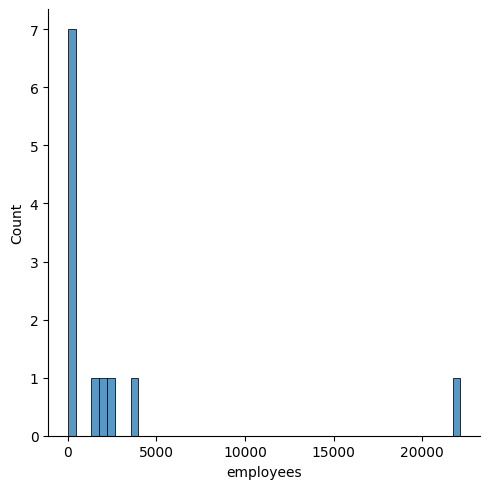

In [48]:
sns.displot(employees, kind='hist', bins=50) # histogram is default kind

Mean is **HEAVILY** skewed because of larger companies like **Novo Nordisk**.

It absolutely does **not** follow normal distribution, but our sample size is tiny, and variance is humongous.

Let's remove outliers and replace missing values with **median**.

(*Since scraping employee data from Proff.dk, we no longer have missing values.*)

In [49]:
lo = employees.quantile(.05)
hi = employees.quantile(.95)
print(lo, hi)
print(employees.quantile([.05,.5,.95])) # other way to get those values. 0.5 included for fun because it's also the median.

14.600000000000001 11970.599999999988
0.05       14.6
0.50       85.0
0.95    11970.6
Name: employees, dtype: float64


In [50]:
no_outliers = employees[(employees < hi) & (employees > lo)]
print(no_outliers)
print(no_outliers.describe())
# median is the same

Dynatest A/S                           36.0
Eriksholm Research Centre, Oticon      42.0
Formpipe                               87.0
PFA                                  1464.0
KMD A/S                              1855.0
NorthTech ApS                          20.0
Alpha Solutions                        59.0
Dafolo                                 83.0
Nuuday A/S                           3642.0
Netcompany A/S                       2340.0
Name: employees, dtype: float64
count      10.000000
mean      962.800000
std      1294.245623
min        20.000000
25%        46.250000
50%        85.000000
75%      1757.250000
max      3642.000000
Name: employees, dtype: float64


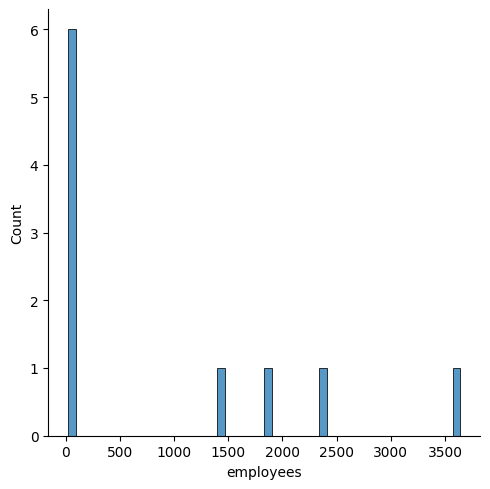

In [51]:
sns.displot(no_outliers, bins=50)

Not much really changed from the previous plot.

In [52]:
df_company.employees.fillna(employees.median(), inplace=True) # median has skipna=True by default
df_company.employees

Dynatest A/S                            36.0
Eriksholm Research Centre, Oticon       42.0
Formpipe                                87.0
Novo Nordisk                         22150.0
PFA                                   1464.0
Topdanmark                               8.0
KMD A/S                               1855.0
NorthTech ApS                           20.0
Alpha Solutions                         59.0
Dafolo                                  83.0
Nuuday A/S                            3642.0
Netcompany A/S                        2340.0
Name: employees, dtype: float64

## Encoding text data
The only real labels I can see are the *city names*, and *industry types*. Cities are kind of already encoded to numerical with ZIP codes, and the industries already have a code used in the API. But let's one-hot encode it anyway.

In [53]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

In [54]:
encoded_data = ohe.fit_transform(df_company[['city', 'industrydesc']])
encoded_data

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0

In [55]:
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['city', 'industrydesc'])).set_index(df_company.index)
# the problem was that the encoded df didn't have the same index as the original df
# so the concat would append new rows instead of replacing the old ones
encoded_df.head()

,city_Bagsværd,city_Ballerup,city_Frederikshavn,city_Herlev,city_København K,city_København SV,city_København Ø,city_Veksø Sjælland,industrydesc_Anden udgivelse af software,"industrydesc_Andre liberale, videnskabelige og tekniske tjenesteydelser i.a.n.","industrydesc_Banker, sparekasser og andelskasser",industrydesc_Computerprogrammering,industrydesc_Fastnetbaseret telekommunikation,industrydesc_Finansielle holdingselskaber,industrydesc_Fremstilling af farmaceutiske præparater,industrydesc_Konsulentbistand vedrørende informationsteknologi,industrydesc_Udgivelse af bøger,industrydesc_Uoplyst
Dynatest A/S,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Eriksholm Research Centre, Oticon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Formpipe,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Nordisk,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
PFA,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df_processed = pd.concat([df_company, encoded_df], axis=1)
df_processed.head()

,vat,name,address,zipcode,city,phone,email,startdate,employees,industrycode,...,industrydesc_Anden udgivelse af software,"industrydesc_Andre liberale, videnskabelige og tekniske tjenesteydelser i.a.n.","industrydesc_Banker, sparekasser og andelskasser",industrydesc_Computerprogrammering,industrydesc_Fastnetbaseret telekommunikation,industrydesc_Finansielle holdingselskaber,industrydesc_Fremstilling af farmaceutiske præparater,industrydesc_Konsulentbistand vedrørende informationsteknologi,industrydesc_Udgivelse af bøger,industrydesc_Uoplyst
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,NaN,NaN,15/10 - 1981,36.0,980000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,NaN,NaN,10/09 - 1974,42.0,749090,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,43660210.0,admin.lasernet@formpipe.com,13/12 - 2001,87.0,582900,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,44448888.0,NaN,28/11 - 1931,22150.0,212000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,70808500.0,post@pfabank.dk,02/11 - 2007,1464.0,641900,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
df_processed.drop(['city', 'industrydesc'], axis=1, inplace=True)